In [1]:
import sys
sys.path.append("../src")
import numpy as np
import nltk
from nltk.tree import Tree
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from iparse import IParser
import evaluate
import torch
import torch_struct

In [2]:
iparse = IParser("../models/gpn_tau_i2_back_kl_c0.01_7921957_dev=94.53.pt")

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
dev_treebank = iparse.load_dev()

In [4]:
matrix = iparse.get_tag_dist(dev_treebank).T

/Users/thomas/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [5]:
# ccg tags?
tag_vocab = {'UNK': 0, '#': 1, '$': 2, "''": 3, ',': 4, '-LRB-': 5, '-RRB-': 6, '.': 7, ':': 8, 'CC': 9, 'CD': 10, 'DT': 11, 'EX': 12, 'FW': 13, 'IN': 14, 'JJ': 15, 'JJR': 16, 'JJS': 17, 'LS': 18, 'MD': 19, 'NN': 20, 'NNP': 21, 'NNPS': 22, 'NNS': 23, 'PDT': 24, 'POS': 25, 'PRP': 26, 'PRP$': 27, 'RB': 28, 'RBR': 29, 'RBS': 30, 'RP': 31, 'SYM': 32, 'TO': 33, 'UH': 34, 'VB': 35, 'VBD': 36, 'VBG': 37, 'VBN': 38, 'VBP': 39, 'VBZ': 40, 'WDT': 41, 'WP': 42, 'WP$': 43, 'WRB': 44, '``': 45}
ind_to_tag = list(tag_vocab.keys())
tagmap = nltk.tag.mapping.tagset_mapping('en-ptb', 'universal')
uni = sorted(list(set(tagmap.values())))
uni_to_ind = {tag: i for i, tag in enumerate(uni)}

In [6]:
# matrix = np.load('../models/tag_dist.npy').T
matrix.shape

(16, 46)

In [11]:
# there was only one UNK tag, ignoring for cleaner data

# uni_mat = np.zeros((16, 11))
# for j in range(matrix.shape[1]):
#     ptb_tag = ind_to_tag[j]
#     uni_tag = tagmap[ptb_tag]
#     i = uni_to_ind[uni_tag]
#     if i < 11:
#         print(ptb_tag, ' converting to ', uni_tag)
#         uni_mat[:, i] += matrix[:, j]
# normalized = np.around((uni_mat.T / (np.sum(uni_mat, axis=1) + 1e-10)), 3).T

# normalized by probability a tag is from a certain word class
normalized = (matrix.T / (np.sum(matrix, axis=1) + 1e-10)).T
df = pd.DataFrame(normalized, columns = ind_to_tag)


In [12]:
np.sum(normalized, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [13]:
df

,UNK,#,$,'',",",-LRB-,-RRB-,.,:,CC,...,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,0.0,0.000000,0.008192,0.009605,0.047316,0.000847,0.001412,0.118503,0.005791,0.028107,...,0.041243,0.010452,0.018362,0.005932,0.013277,0.003390,0.001271,0.000000,0.002401,0.009746
1,0.0,0.000000,0.008055,0.001151,0.018412,0.001151,0.002301,0.002301,0.000000,0.009206,...,0.073648,0.005754,0.003452,0.020713,0.041427,0.000000,0.000000,0.001151,0.000000,0.001151
2,0.0,0.000000,0.004137,0.003546,0.031915,0.000000,0.000000,0.020686,0.005910,0.017730,...,0.106383,0.017730,0.035461,0.023641,0.043144,0.000000,0.002364,0.000000,0.004728,0.005910
3,0.0,0.000000,0.001821,0.009107,0.047966,0.001214,0.000000,0.088646,0.011536,0.024894,...,0.059502,0.004857,0.007286,0.012143,0.027930,0.001214,0.003643,0.000000,0.003643,0.013965
4,0.0,0.000000,0.009732,0.000000,0.024331,0.000000,0.002433,0.019465,0.000000,0.000000,...,0.104623,0.036496,0.034063,0.007299,0.055961,0.000000,0.002433,0.000000,0.004866,0.000000
5,0.0,0.000000,0.000000,0.010714,0.103571,0.003571,0.003571,0.071429,0.014286,0.103571,...,0.025000,0.007143,0.003571,0.003571,0.003571,0.000000,0.003571,0.000000,0.000000,0.010714
6,0.0,0.000000,0.020619,0.003436,0.051546,0.006873,0.000000,0.030928,0.003436,0.044674,...,0.010309,0.010309,0.000000,0.003436,0.013746,0.000000,0.003436,0.000000,0.000000,0.006873
7,0.0,0.000000,0.007421,0.011132,0.090909,0.000000,0.003711,0.033395,0.005566,0.020408,...,0.016698,0.005566,0.001855,0.005566,0.012987,0.000000,0.000000,0.000000,0.000000,0.007421
8,0.0,0.000000,0.014100,0.011931,0.063991,0.002169,0.002169,0.033623,0.003254,0.028200,...,0.024946,0.010846,0.018438,0.005423,0.009761,0.002169,0.000000,0.001085,0.001085,0.004338
9,0.0,0.000000,0.008316,0.004158,0.113306,0.000000,0.006237,0.068607,0.009356,0.068607,...,0.025988,0.018711,0.012474,0.004158,0.008316,0.012474,0.001040,0.003119,0.003119,0.057173


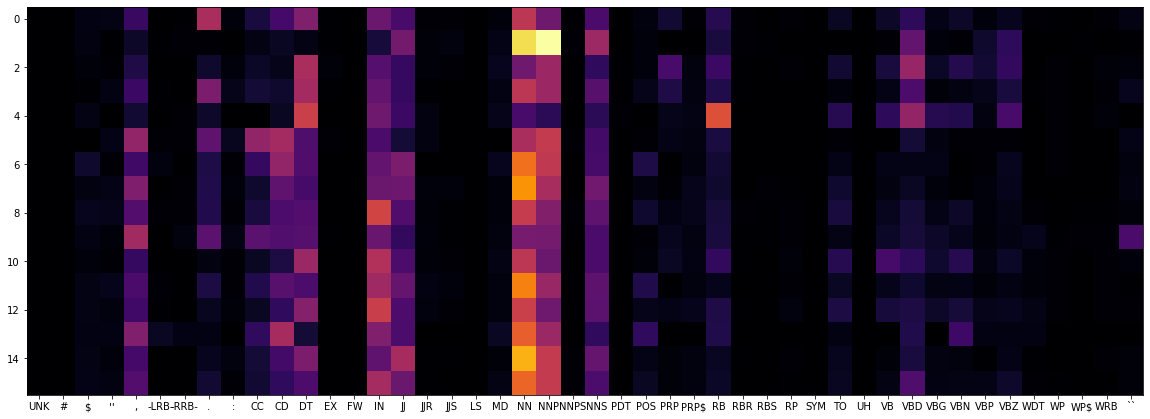

In [14]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
# ax.figure()
ax.imshow(normalized, cmap='inferno', interpolation='nearest')
ax.set_xticks(np.arange(46))
ax.set_xticklabels(ind_to_tag)
plt.show()

In [4]:
import benepar
benepar.download('benepar_en3_wsj')
parser = benepar.Parser("benepar_en3_wsj")
original_parser = parser._parser

[nltk_data] Downloading package benepar_en3_wsj to
[nltk_data]     /Users/thomas/nltk_data...
[nltk_data]   Unzipping models/benepar_en3_wsj.zip.


In [5]:
def get_struct_dist(score):
    length, length, tags = score.shape
    score = score.reshape((1, length, length, tags))
    score = score - score[..., :1]
    dist = torch_struct.TreeCRF(torch.Tensor(score), lengths=torch.LongTensor(np.array([length])))
    return dist.argmax
    

def get_skyline_trees(original_parser, iparse):

    scores = original_parser.parse(
        dev_treebank.without_gold_annotations(),
        subbatch_max_tokens=2000,
        return_scores=True
    )
    struc_scores = iparse.parser.parse(
        dev_treebank.without_gold_annotations(),
        subbatch_max_tokens=2000,
        return_scores=True
    )
    
    for i in range(len(scores)):
        score = np.copy(scores[i])
        struc_score = struc_scores[i]
        struct_max = get_struct_dist(struc_score).max(-1).values[0]

        score[struct_max < 1, 1:] = -1e10
        amax = get_struct_dist(score)
        amax[..., 0] += 1e-9
        padded_charts = amax.argmax(-1)
        padded_charts = padded_charts.detach().cpu().numpy()
        chart = padded_charts[0]
        leaves = dev_treebank[i].pos()
        out = original_parser.decoder.tree_from_chart(chart, leaves=leaves)
        yield out

In [6]:
trees = get_skyline_trees(original_parser, iparse)
trees = list(trees)

KeyboardInterrupt: 

In [6]:
scores = original_parser.parse(
    dev_treebank.without_gold_annotations(),
    subbatch_max_tokens=2000,
    return_scores=True
)
struc_scores = iparse.parser.parse(
    dev_treebank.without_gold_annotations(),
    subbatch_max_tokens=2000,
    return_scores=True
)


In [7]:
trees = []
for i in range(len(scores)):
    score = np.copy(scores[i])
    struc_score = struc_scores[i]
    struct_max = get_struct_dist(struc_score).max(-1).values[0]

    score[struct_max < 1, 1:] = -1e10
    length, length, tags = score.shape
    charts = original_parser.decoder.charts_from_pytorch_scores_batched(
        torch.Tensor(score.reshape(1, length, length, tags)), lengths=torch.LongTensor(np.array([length])))
    leaves = dev_treebank[i].pos()
    out = original_parser.decoder.tree_from_chart(charts[0], leaves=leaves)
    trees.append(out)

/Users/thomas/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [8]:
original_trees = original_parser.parse(
    dev_treebank.without_gold_annotations(),
    subbatch_max_tokens=2000
)

In [9]:
evalb_dir="../EVALB_labeled/"
dev_fscore = evaluate.evalb(
    evalb_dir, dev_treebank.trees, trees)
print(dev_fscore)
#dev=94.53

(Recall=93.22, Precision=96.13, FScore=94.65, CompleteMatch=44.68)


In [10]:
evalb_dir="../EVALB_labeled/"
dev_fscore = evaluate.evalb(
    evalb_dir, dev_treebank.trees, original_trees)
print(dev_fscore)

(Recall=95.68, Precision=95.76, FScore=95.72, CompleteMatch=56.05, TaggingAccuracy=97.16)
